In [1]:
!pip install mlxtend --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0


In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


In [3]:
!wget https://www.dropbox.com/scl/fi/9d460d91ta9fq2hc3c0yb/hotel_bookings.zip?rlkey=0244nwxr33g0piz2t9l5r2r0b&dl=0  -O hotel_bookings.zip


/bin/bash: line 1: -O: command not found
--2024-02-10 18:03:34--  https://www.dropbox.com/scl/fi/9d460d91ta9fq2hc3c0yb/hotel_bookings.zip?rlkey=0244nwxr33g0piz2t9l5r2r0b
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b720a046e38d2f9704a83155b.dl.dropboxusercontent.com/cd/0/inline/CNDaVgtNRK7LTBw0XWSTfpzovsrk8xJSAtf-WHSIIqNKB4e_JE6MYwISXgsW2mKHpBIiH163XLH5_p6TxEDtWX8J5eb56pnDx3rBf0dmkWV9GeSwa4w1uMt8XydW8dPLHSCe15EFrAPBymGgkSfTZukY/file# [following]
--2024-02-10 18:03:35--  https://uc5b720a046e38d2f9704a83155b.dl.dropboxusercontent.com/cd/0/inline/CNDaVgtNRK7LTBw0XWSTfpzovsrk8xJSAtf-WHSIIqNKB4e_JE6MYwISXgsW2mKHpBIiH163XLH5_p6TxEDtWX8J5eb56pnDx3rBf0dmkWV9GeSwa4w1uMt8XydW8dPLHSCe15EFrAPBymGgkSfTZukY/file
Resolving uc5b720a046e38d2f9704a83155b.dl.dropboxusercontent.com (uc5b720a046e38d2f9704a83155b.dl.

In [4]:

!unzip -q hotel_bookings.zip?rlkey=0244nwxr33g0piz2t9l5r2r0b

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler ,MinMaxScaler,LabelEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import itertools
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings("ignore")


NOT : class ClfSwitcher

the class allow ın greadsearh or randomsearch at the same time
 train different model with deffirent paramets
and find rank not only 1 model performance
 but also several models together
  :I did not love stacking models or other kind of tools

In [6]:
def dataframe_info(df):
    print("dataframe shape is :", df.shape)
    columns_x = df.copy()
    tmp = []

    for col in columns_x:
        ser = df[col]
        tmp.append({
            'name': ser.name,
            'dtype': str(ser.dtype),
            'n_unique': len(ser.unique()),
            'n_null': ser.isnull().sum(),
        })
    df_info = pd.DataFrame(tmp)
    display(df_info)

def duplicates(data : pd.DataFrame) -> pd.DataFrame:
  print('old shape is' ,data.shape)
  if data.duplicated().any() == True:
    #check for duplicate rows based on all columns
    duplicates_all_columns = data[data.duplicated()]
    display(duplicates_all_columns.head(2))
    #To count the number of duplicates
    num_duplicates = data.duplicated().sum()
    print("duplicated values are : " ,num_duplicates)

    data.drop_duplicates( keep='first',inplace=True)
  print("new shape is : ")
  display(data.shape)

  return data


def nan_values_handle(data):
  print("missing_values")
  print("data_shape :" ,data.shape)
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  display(missing_value_df.sort_values(ascending=False,by="percent_missing")[:50])

  print("drop_cols_with_more_then_nan_values_0.6%")
  missing_data_high=missing_value_df["percent_missing"]>10
  display(missing_data_high[missing_data_high==True].index)

  drop_cols=missing_data_high[missing_data_high==True].index
  data.drop(drop_cols,axis=1,inplace=True)
  display(data.shape)
  return data

def split(X,y):
   X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)
   print('Training Features Shape:', X_train.shape)
   print('Training Labels Shape:', y_train.shape)
   print('Testing Features Shape:', X_val.shape)
   print('Testing Labels Shape:', y_val.shape)
   return X_train,X_val,y_train,y_val


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LogisticRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

def result(X_train,X_val,y_train,y_val,estimator):
  best=estimator
  best.fit(X_train, y_train)

  y_predict=best.predict(X_val)

  scoring = {'ACC': 'accuracy',
             'F1': 'f1',
             'Precision': 'precision',
             'Recall': 'recall'}

  scores = cross_validate(best, X_train, y_train,
                         scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42),
                         return_train_score=True)


  print('croos_validate''s results  ')
  DF_cv = pd.DataFrame(scores)
  display(DF_cv)
  print('\n')
  print(DF_cv.mean()[2:])

  print(classification_report(y_val, y_predict, target_names=['canceled','not canceled']))

def curve(y_val,y_predict):
  from sklearn.metrics import auc

  # Calculate precision-recall curve
  precision, recall, _ = precision_recall_curve(y_val,
                                                y_predict)

  # Calculate area under the precision-recall curve
  auc_pr = auc(recall, precision)

  # Plot precision-recall curve
  plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

def plot_confusion_matrix(cm, classes,normalize=False):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

def show_metrics(cm):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))


class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold


    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        fscores = (2 * precisions * recalls) / (precisions + recalls)

        optimal_idx = np.argmax(fscores)

        return thresholds[optimal_idx], fscores[optimal_idx]

In [7]:
#find encoding
from chardet.universaldetector import UniversalDetector
detector = UniversalDetector()
with open('hotel_bookings.csv', 'rb') as fh:
    for line in fh:
        detector.feed(line)
        if detector.done:
            break
detector.close()


{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [8]:
df=pd.read_csv("./hotel_bookings.csv",encoding="ascii")
display(df.head(2))

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


In [9]:
df['reservation_status_date']=pd.to_datetime(df['reservation_status_date'], format='%Y-%m-%d %H:%M:%S')
#WE CAN SET timestamp as index column if further analys needed .

In [10]:
#lets create a arrival date column
df['date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str))
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01


In [11]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.columns[df.dtypes == 'object']

In [12]:
filter=(df.children==0)&(df.adults==0)&(df.babies==0)
mask=df[filter][["is_canceled","children","babies","adults","date","reservation_status_date"]]
display(mask.head(2))
display(mask[mask["is_canceled"]==1].head(2))

,is_canceled,children,babies,adults,date,reservation_status_date
2224,0,0.0,0,0,2015-10-06,2015-10-06
2409,0,0.0,0,0,2015-10-12,2015-10-12


,is_canceled,children,babies,adults,date,reservation_status_date
4127,1,0.0,0,0,2016-02-15,2016-02-15
9376,1,0.0,0,0,2016-11-21,2016-11-21


In [13]:
df=df[~(filter)]

In [14]:
def week_function(feature1, feature2, data_source):
    data_source['weekend_or_weekday'] = 0
    for i in range(0, len(data_source)):
        if feature2.iloc[i] == 0 and feature1.iloc[i] > 0:
            df['weekend_or_weekday'].iloc[i] = 'stay_just_weekend'
        if feature2.iloc[i] > 0 and feature1.iloc[i] == 0:
            df['weekend_or_weekday'].iloc[i] = 'stay_just_weekday'
        if feature2.iloc[i] > 0 and feature1.iloc[i] > 0:
            df['weekend_or_weekday'].iloc[i] = 'stay_both_weekday_and_weekend'
        if feature2.iloc[i] == 0 and feature1.iloc[i] == 0:
            df['weekend_or_weekday'].iloc[i] = 'undefined_data'

week_function(df['stays_in_weekend_nights'],df['stays_in_week_nights'],df)

In [15]:
df.weekend_or_weekday.unique()

array(['undefined_data', 'stay_just_weekday',
       'stay_both_weekday_and_weekend', 'stay_just_weekend'], dtype=object)

In [16]:
new_filter=df.weekend_or_weekday=='undefined_data'
df[new_filter].head(2)
display(df[new_filter].shape)

(645, 34)

In [17]:
df=df[~(new_filter)]
df.drop('weekend_or_weekday',axis=1,inplace=True)

In [18]:
df=duplicates(df)
df.head(2)

old shape is (118565, 33)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,...,250.0,NaN,0,Transient,84.67,0,1,Check-Out,2015-07-07,2015-07-01


duplicated values are :  31926
new shape is : 


(86639, 33)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01


In [19]:
df.duplicated().sum()

0

In [20]:
file_name='df_viz.csv'
df.to_csv(file_name, encoding='ascii',index=False)

#Numerical Columns

In [21]:
display(df[num_cols].head(2))
display(df[num_cols].shape)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2,0,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,NaN,NaN,0,75.0,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,304.0,NaN,0,75.0,0,0


(86639, 20)

In [22]:
dataframe_info(df[num_cols])

dataframe shape is : (86639, 20)


,name,dtype,n_unique,n_null
0,is_canceled,int64,2,0
1,lead_time,int64,478,0
2,arrival_date_year,int64,3,0
3,arrival_date_week_number,int64,53,0
4,arrival_date_day_of_month,int64,31,0
5,stays_in_weekend_nights,int64,17,0
6,stays_in_week_nights,int64,33,0
7,adults,int64,14,0
8,children,float64,6,4
9,babies,int64,5,0


In [23]:
for row in df[num_cols].columns:
  display(print(f'(column name : {row} and unique values is :',df[num_cols][row].unique()))

(column name : is_canceled and unique values is : [0 1]


None

(column name : lead_time and unique values is : [  7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78  48  60
  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113  90  50
  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364 324  79
  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8 100  44
  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112  65  67
  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108 106  31
  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57  19  25
 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124 327 131
 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157 147 138
 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340 356 142
 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165 172 171
 145 121 178 305 173 152 354 347 158 185 349 183 352 177 200 192 361 207
 174 330 134 350 334 283 197 133 153 241 193 235 194 261 260 216 169 209
 23

None

(column name : arrival_date_year and unique values is : [2015 2016 2017]


None

(column name : arrival_date_week_number and unique values is : [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26]


None

(column name : arrival_date_day_of_month and unique values is : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


None

(column name : stays_in_weekend_nights and unique values is : [ 0  1  2  4  3  6 13  8  5  7 12  9 16 18 19 10 14]


None

(column name : stays_in_week_nights and unique values is : [ 1  2  3  4  5 10 11  8  6  7 15  0  9 12 33 20 14 16 21 13 30 19 24 40
 22 42 50 25 17 32 26 18 34]


None

(column name : adults and unique values is : [ 1  2  3  4 40 26 50 27 55 20  6  5 10  0]


None

(column name : children and unique values is : [ 0.  1.  2. 10.  3. nan]


None

(column name : babies and unique values is : [ 0  1  2 10  9]


None

(column name : is_repeated_guest and unique values is : [0 1]


None

(column name : previous_cancellations and unique values is : [ 0  1  2  3 26 25 14  4 24 19  5 21  6 13 11]


None

(column name : previous_bookings_not_canceled and unique values is : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 27 28 29 30 19 26 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]


None

(column name : booking_changes and unique values is : [ 0  1  2  3  5  4 17  6  8  7 10 16  9 13 12 14 15 18 11]


None

(column name : agent and unique values is : [ nan 304. 240. 303.  15. 241.   8. 250. 115.   5. 175. 134. 156. 243.
 242.   3. 105.  40. 147. 306. 184.  96.   2. 127.  95. 146.   9. 177.
   6. 143. 244. 149. 167. 300. 171. 305.  67. 196. 152. 142. 261. 104.
  36.  26.  29. 258. 110.  71. 181.  88. 251. 275.  69. 248. 208. 256.
 314. 126. 281. 273. 253. 185. 330. 334. 328. 326. 321. 324. 313.  38.
 155.  68. 335. 308. 332.  94. 348. 310. 339. 375.  66. 327. 387. 298.
  91. 245. 385. 257. 393. 168. 405. 249. 315.  75. 128. 307.  11. 436.
   1. 201. 183. 223. 368. 336. 291. 464. 411. 481.  10. 154. 468. 410.
 390. 440. 495. 492. 493. 434.  57. 531. 420. 483. 526. 472. 429.  16.
 446.  34.  78. 139. 252. 270.  47. 114. 301. 193. 182. 135. 350. 195.
 352. 355. 159. 363. 384. 360. 331. 367.  64. 406. 163. 414. 333. 427.
 431. 430. 426. 438. 433. 418. 441. 282. 432.  72. 450. 454. 455.  59.
 451. 254. 180. 358. 469. 165. 467. 510. 337. 476. 502. 527. 479. 508.
 535. 302. 497. 187.  13.   7.  2

None

(column name : company and unique values is : [ nan 110. 113. 270. 178. 240. 154. 144. 307. 268.  59. 204. 312. 318.
  94. 274. 174. 195. 223. 317. 281. 118.  53. 286.  12.  47. 324. 342.
 373. 371.  86.  82. 218.  88.  31. 397. 392. 405. 331. 367.  20.  83.
 416.  51. 395. 102.  34.  84. 360. 394. 457. 382. 461. 478. 112. 486.
 421.   9. 308. 135. 224. 504. 269. 356. 498. 390. 513. 203. 263. 477.
 521. 169. 515. 445. 337. 251. 428. 292. 388. 130. 250. 355. 254. 543.
 531. 528.  62. 120.  42.  81. 116. 530. 103.  39.  16.  92.  61. 501.
 165. 291. 290.  43. 325. 192. 108. 200. 465. 287. 297. 490. 482. 207.
 282. 437. 225. 329. 272.  28.  77. 338.  72. 246. 319. 146. 159. 380.
 323. 511. 407. 278.  80. 403. 399.  14. 137. 343. 346. 347. 349. 289.
 351. 353.  54.  99. 358. 361. 362. 366. 372. 365. 277. 109. 377. 379.
  22. 378. 330. 364. 401. 232. 255. 384. 167. 212. 514. 391. 400. 376.
 402. 396. 302. 398.   6. 370. 369. 409. 168. 104. 408. 413. 148.  10.
 333. 419. 415. 424. 425. 423. 

None

(column name : days_in_waiting_list and unique values is : [  0  50  47  65 122  75 101 150 125  14  60  34 100  22 121  61  39   5
   1   8 107  43  52   2  11 142 116  13  44  97  83   4 113  18  20 185
  93 109   6  37 105 154  64  99  38  48  33  77  21  80  59  40  58  89
  53  49  69  87  91  57 111  79  98  85  63  15   3  41 224  31  56 187
 176  71  55  96 236 259 207 215 160 120  30  32  27  62  24 108 147 379
  70  35 178 330 223 174 162 391  68 193  10  76  16  28   9 165  17  25
  46   7  84 175 183  23 117  12  54  26  73  45  19  42  72  81  74 167
  36]


None

(column name : adr and unique values is : [ 75.    98.   107.   ... 266.75 209.25 157.71]


None

(column name : required_car_parking_spaces and unique values is : [0 1 2 8 3]


None

(column name : total_of_special_requests and unique values is : [0 1 3 2 4 5]


None

#column name-agent (dtype ---> int64)
 have float dtype , after checking nan values if needed column will be deleted

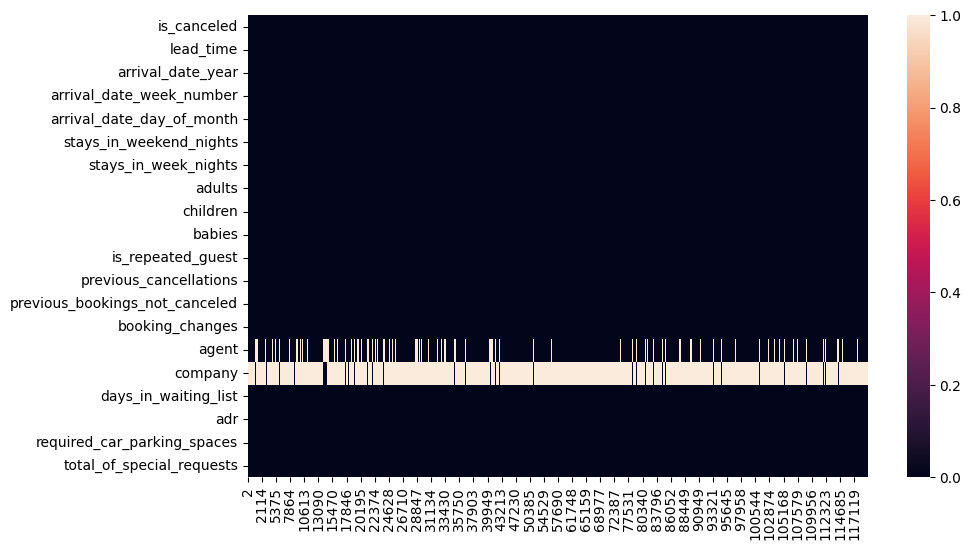

In [24]:
#nan_values oh numerical cols
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].isna().transpose());

In [25]:
df_numerical=nan_values_handle(df[num_cols])


missing_values
data_shape : (86639, 20)


,column_name,percent_missing
company,company,94.032710
agent,agent,13.802098
children,children,0.004617
is_canceled,is_canceled,0.000000
previous_cancellations,previous_cancellations,0.000000
required_car_parking_spaces,required_car_parking_spaces,0.000000
adr,adr,0.000000
days_in_waiting_list,days_in_waiting_list,0.000000
booking_changes,booking_changes,0.000000
previous_bookings_not_canceled,previous_bookings_not_canceled,0.000000


drop_cols_with_more_then_nan_values_0.6%


Index(['agent', 'company'], dtype='object')

(86639, 18)

In [26]:
df_numerical['total_guests'] = df_numerical['adults'] + df_numerical['children'] + df_numerical['babies']
df_numerical['total_guests'].head()

2    1.0
3    1.0
4    2.0
6    2.0
7    2.0
Name: total_guests, dtype: float64

In [27]:
# get the total room nights stayed based on arrival date
df_numerical['total_nigths'] = df_numerical['stays_in_week_nights'] + df_numerical['stays_in_weekend_nights']
df_numerical['total_nigths'].tail()

119385    7
119386    7
119387    7
119388    7
119389    9
Name: total_nigths, dtype: int64

In [28]:
drop_columns=[
   'stays_in_week_nights',
   'stays_in_weekend_nights',
   'adults',
   'children',
   'babies',
   'arrival_date_year',
   'arrival_date_day_of_month',
]
df_numerical.drop(columns=drop_columns,axis=1,inplace=True)

In [29]:
#add new feature
df_numerical['add'] = df_numerical.groupby(['previous_bookings_not_canceled'])['previous_cancellations'].transform('sum')


In [30]:
df_numerical.previous_bookings_not_canceled.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 19, 26, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

In [31]:
labels = [1, 2, 3, 4]

# Apply pd.cut() to create a new column 'add_2'
df_numerical['add_2'] = pd.cut(df_numerical['previous_bookings_not_canceled'], bins=4, labels=labels, right=False)

# Convert the datatype to integer
df_numerical['add_2'] = df_numerical['add_2'].astype(int)

In [32]:
df_numerical['add_3'] = df_numerical.groupby(['required_car_parking_spaces'])['add_2'].transform('sum')


In [33]:
df_numerical.describe().transpose().style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
is_canceled,86639.000000,0.276850,0.447444,0.000000,0.000000,0.000000,1.000000,1.000000
lead_time,86639.000000,80.293090,86.073687,0.000000,12.000000,50.000000,126.000000,709.000000
arrival_date_week_number,86639.000000,26.822228,13.652413,1.000000,16.000000,27.000000,37.000000,53.000000
is_repeated_guest,86639.000000,0.036300,0.187037,0.000000,0.000000,0.000000,0.000000,1.000000
previous_cancellations,86639.000000,0.030564,0.370535,0.000000,0.000000,0.000000,0.000000,26.000000
previous_bookings_not_canceled,86639.000000,0.184409,1.737150,0.000000,0.000000,0.000000,0.000000,72.000000
booking_changes,86639.000000,0.268170,0.709928,0.000000,0.000000,0.000000,0.000000,18.000000
days_in_waiting_list,86639.000000,0.750251,10.029423,0.000000,0.000000,0.000000,0.000000,391.000000
adr,86639.000000,107.244634,54.366121,-6.380000,72.900000,99.000000,134.435000,5400.000000
required_car_parking_spaces,86639.000000,0.084696,0.282260,0.000000,0.000000,0.000000,0.000000,8.000000


adr- min: -6.38

In [34]:
test=df_numerical[df_numerical["adr"]<0]
test

,is_canceled,lead_time,arrival_date_week_number,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_guests,total_nigths,add,add_2,add_3
14969,0,195,10,1,0,2,2,0,-6.38,0,0,2.0,10,77,1,79541


In [35]:
df_numerical[~(df_numerical["adr"] < 0)]['adr'].describe()

count    86638.000000
mean       107.245945
std         54.365064
min          0.000000
25%         72.900000
50%         99.000000
75%        134.437500
max       5400.000000
Name: adr, dtype: float64

While Pearson's correlation coefficient is most effective when the variables are normally distributed, its use is not strictly limited to use in differen approach.

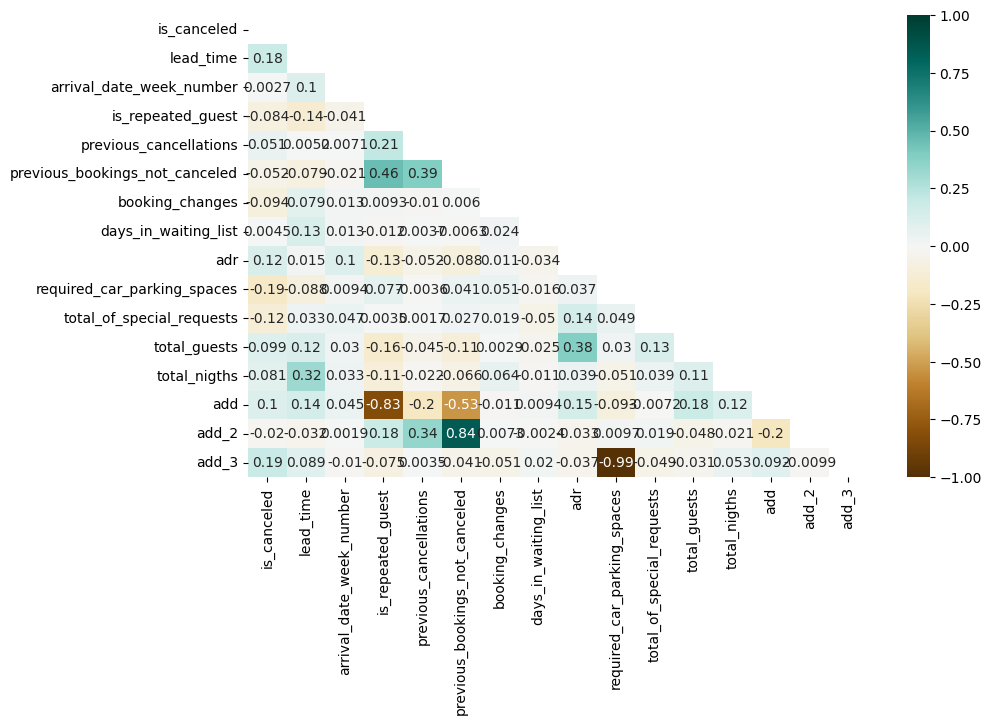

In [36]:
corr_matrix = df_numerical.corr(method='pearson') #method='pearson'for linearity ,we can use also Spearman's Rank Correlation Coefficient
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))
# Plot heatmap
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Show the plot
plt.show()


drop columns which contains  multycorrelation simulation - [add , is repeated_guest : -0.8]

also drop columns which std() is so low : like booking_changes 0.727245

In [37]:
new_drop=[
    'add_2',
    'required_car_parking_spaces',
    'booking_changes',
    'days_in_waiting_list',
    'total_nigths',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'is_repeated_guest',
    'arrival_date_week_number'
]
df_numerical.drop(columns=new_drop,axis=1,inplace=True)

now we choose spearman correlation between variables(numerical)

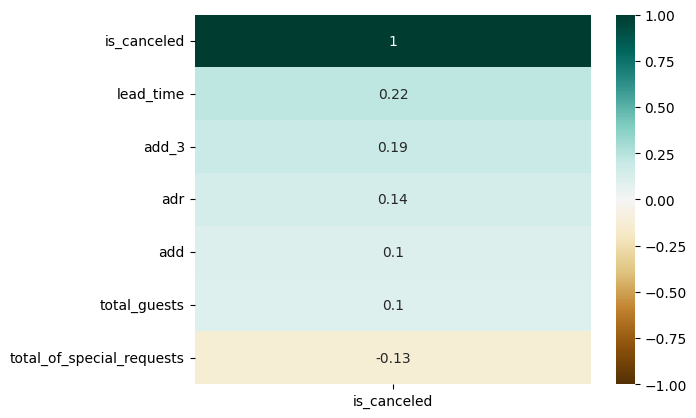

In [38]:
heatmap = sns.heatmap(df_numerical.corr(method='spearman')[['is_canceled']].sort_values(by='is_canceled',
                                                                                          ascending=False),
                                                                                           vmin=-1, vmax=1, annot=True, cmap='BrBG')


#Categorical Columns

In [39]:
display(df[cat_cols].describe(include='object').transpose())


,count,unique,top,freq
hotel,86639,2,City Hotel,53043
arrival_date_month,86639,12,August,11194
meal,86639,5,BB,67419
country,86197,177,PRT,26864
market_segment,86639,8,Online TA,51285
distribution_channel,86639,5,TA/TO,68651
reserved_room_type,86639,9,A,56010
assigned_room_type,86639,11,A,46089
deposit_type,86639,3,No Deposit,85494
customer_type,86639,4,Transient,71366


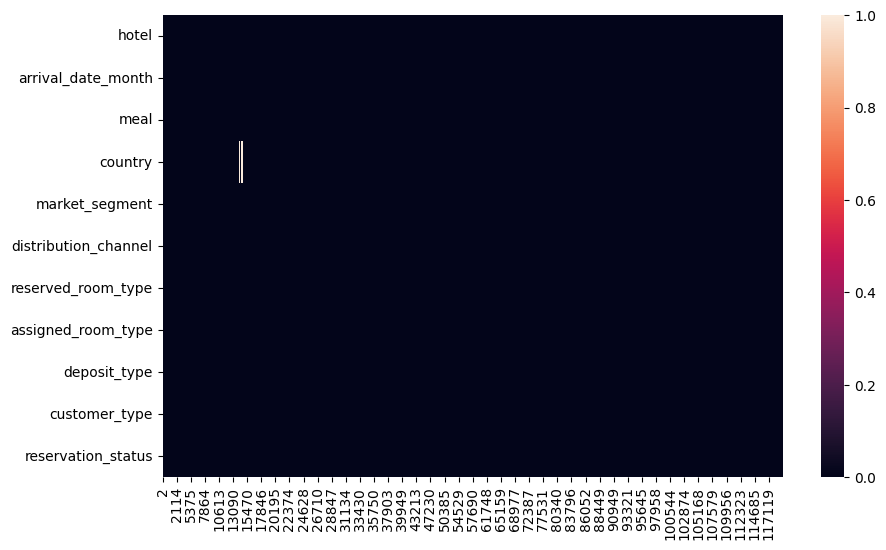

In [40]:
plt.figure(figsize=(10,6))
sns.heatmap(df[cat_cols].isna().transpose());

In [41]:
for row in df[cat_cols].columns:
  display(print(f'(column name : {row} and unique values is :',df[row].unique()))

(column name : hotel and unique values is : ['Resort Hotel' 'City Hotel']


None

(column name : arrival_date_month and unique values is : ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']


None

(column name : meal and unique values is : ['BB' 'FB' 'HB' 'SC' 'Undefined']


None

(column name : country and unique values is : ['GBR' 'PRT' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB' 'NPL'
 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA' 'QAT'
 'KHM' 'MCO' 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA' 'GAB' 'GHA' 'TMP'
 'GLP' 'KEN' 'LIE' 'GNB' 'MNE' 'UMI' 'MYT' 'FRO' 'MMR' 'PAN' 'BFA' 'LBY'
 'MLI' '

None

(column name : market_segment and unique values is : ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']


None

(column name : distribution_channel and unique values is : ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']


None

(column name : reserved_room_type and unique values is : ['A' 'C' 'D' 'E' 'G' 'F' 'H' 'L' 'B']


None

(column name : assigned_room_type and unique values is : ['C' 'A' 'D' 'E' 'G' 'F' 'I' 'B' 'H' 'L' 'K']


None

(column name : deposit_type and unique values is : ['No Deposit' 'Refundable' 'Non Refund']


None

(column name : customer_type and unique values is : ['Transient' 'Contract' 'Transient-Party' 'Group']


None

(column name : reservation_status and unique values is : ['Check-Out' 'Canceled' 'No-Show']


None

In [42]:
df_cat=df[cat_cols].copy()
#df_cat.drop( 'arrival_date_month',axis=1,inplace=True)

In [43]:
country_counts=df_cat.country.value_counts()[:110]
country_counts

PRT    26864
GBR    10401
FRA     8813
ESP     7228
DEU     5385
       ...  
CIV        6
LKA        6
JAM        6
MNE        5
BHR        5
Name: country, Length: 110, dtype: int64

In [44]:
top_110_countries=df_cat.country.head(110).values
df_cat.country = df_cat.country.apply(lambda x: x if x in top_110_countries else 'rare')


In [45]:
df_cat[df_cat.country=='rare'].shape

(17472, 11)

In [46]:
df_cat.country.unique()

array(['GBR', 'PRT', 'USA', 'ESP', 'IRL', 'FRA', 'rare', 'ROU', 'NOR',
       'OMN', 'ARG', 'POL', 'DEU', 'BEL', 'CHE'], dtype=object)

In [47]:
month_order = ['January', 'February', 'March', 'April', 'May',
               'June', 'July', 'August', 'September',
               'October', 'November', 'December']
df_cat['arrival_date_month'] = df_cat['arrival_date_month'].apply(lambda x: month_order.index(x) + 1)

In [48]:
mapping = {'Resort Hotel': 1, 'City Hotel': 0}
# Apply the mapping
df_cat['hotel'] = df_cat['hotel'].map(mapping)


In [49]:
new_df=pd.DataFrame()
for column in df[cat_cols]:
  new_df[column]=TargetEncoder().fit_transform(df[column],df['is_canceled'])


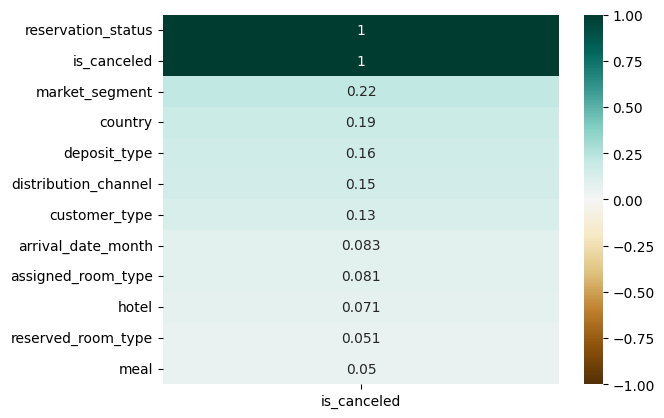

In [50]:
new_df['is_canceled']=df.is_canceled
heatmap = sns.heatmap(new_df.corr(method='spearman')[['is_canceled']].sort_values(by='is_canceled',
                                                                                          ascending=False),
                                                                                           vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [51]:
df_cat.drop(['reservation_status'],axis=1,inplace=True)

In [52]:
display(df_cat.shape)
display(df_numerical.shape)
df_cat.shape[0]==df_numerical.shape[0]==df.shape[0]

(86639, 10)

(86639, 7)

True

In [53]:
joined_list = [*df_numerical.columns, *df_cat.columns] # unpack both iterables in a list literal print(joined_list)
display(len(joined_list))

17

In [54]:
final_df=pd.concat([df_numerical,df_cat],axis=1)
display(final_df.shape)
display(final_df.head(2))

(86639, 17)

,is_canceled,lead_time,adr,total_of_special_requests,total_guests,add,add_3,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
2,0,7,75.0,0,1.0,1311,79541,1,7,BB,GBR,Direct,Direct,A,C,No Deposit,Transient
3,0,13,75.0,0,1.0,1311,79541,1,7,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient


In [55]:
file_name='final_df_viz.csv'
final_df.to_csv(file_name, encoding='ascii',index=False)

Data Preprocessing

In [56]:
y = final_df['is_canceled']
X = final_df.drop('is_canceled', axis = 1)

In [57]:
X.isna().sum()

lead_time                    0
adr                          0
total_of_special_requests    0
total_guests                 4
add                          0
add_3                        0
hotel                        0
arrival_date_month           0
meal                         0
country                      0
market_segment               0
distribution_channel         0
reserved_room_type           0
assigned_room_type           0
deposit_type                 0
customer_type                0
dtype: int64

In [58]:
num_cols = X.select_dtypes(include=np.number).columns
extra_cat_cols=[num_cols[-2],num_cols[-1]]
num_cols=[item for item in num_cols if item not in extra_cat_cols]
cat_cols = X.columns[X.dtypes == 'object']
print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 6 numeric columns: lead_time, adr, total_of_special_requests, total_guests, add, add_3
And 8 categorical columns: meal, country, market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, customer_type


In [59]:
extra_cat_cols

['hotel', 'arrival_date_month']

In [60]:
X_train,X_val,y_train,y_val= split(X,y)

Training Features Shape: (69311, 16)
Training Labels Shape: (69311,)
Testing Features Shape: (17328, 16)
Testing Labels Shape: (17328,)


In [61]:
display(y_train.value_counts(normalize=True))
display(y_val.value_counts(normalize=True))

0    0.72293
1    0.27707
Name: is_canceled, dtype: float64

0    0.72403
1    0.27597
Name: is_canceled, dtype: float64

In [62]:
numerical_pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('poly', PolynomialFeatures(degree=1)), #include_bias=False
    ('scaler', MinMaxScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols),
    ('pass', 'passthrough', extra_cat_cols)  # 'passthrough' means no transformation
])

X_train = preprocessors.fit_transform(X_train, y_train)
X_test = preprocessors.transform(X_val)


In [63]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
sel_= SelectFromModel(LogisticRegression(penalty='l1', C=1/0.005,
                                         solver='liblinear',
                                         random_state=0)) #C inverse of regularization strength
# train Lasso model and select features
sel_.fit(X_train,y_train)
# let's print the number of total and selected features

SelectFromModel(estimator=LogisticRegression(C=200.0, penalty='l1',
                                             random_state=0,
                                             solver='liblinear'))

In [64]:
# let's print the number of total and selected features
selected_feats = pd.DataFrame(X_train).columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total features: 17
selected features: 16
features with coefficients shrank to zero: 1


In [65]:
selected_feats

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64')

In [66]:
X_train=pd.DataFrame(X_train).iloc[:,selected_feats]
X_test=pd.DataFrame(X_test).iloc[:,selected_feats]

#training

#Not

(ROC) Curve: Plot the ROC curve and analyze the trade-off between true positive rate (TPR) and false positive rate (FPR) at different threshold values. The ROC curve helps visualize the performance of the classifier across various threshold values.

Due to imbalanced classes, we cannot effectively evaluate using the ROC curve. Instead, we will utilize precision-recall curves. It's essential to assess the model's performance independently of the threshold, focusing on metrics such as precision, recall, and F1-score.

it's important to keep in mind that changing the threshold may impact other evaluation metrics. For example, increasing the threshold to reduce false positives may lead to a decrease in recall (true positive rate). Therefore, it's crucial to consider the trade-offs and select the threshold that aligns with your specific goals and constraints. Additionally, thorough testing and validation should be conducted to ensure that changes to the threshold yield the desired results without unintended consequences.





#Random_forest

let's try to find optimal parametrs based on graph

100%|██████████| 99/99 [10:28<00:00,  6.35s/it]


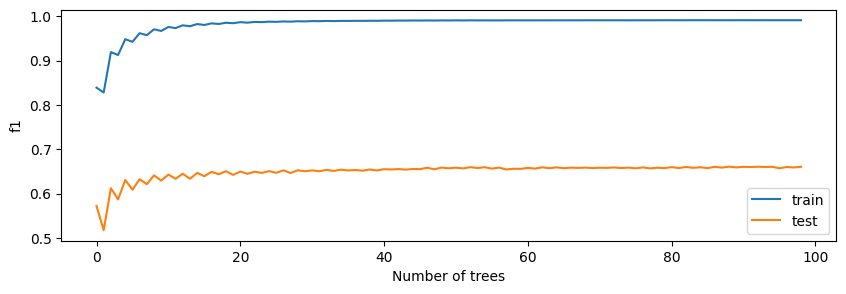

In [68]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
plt.rcParams["figure.figsize"] = (10, 3)

train_f1, test_f1 = [], []
n_trees = 100
for i in tqdm(range(1, n_trees)):
    model = RandomForestClassifier(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    train_f1.append(f1(y_train, model.predict(X_train)))
    test_f1.append(f1(y_val, model.predict(X_test)))

plt.plot(train_f1, label='train')
plt.plot(test_f1, label='test')
plt.xlabel('number of trees')
plt.ylabel('f1')
plt.xlabel('Number of trees')
plt.legend();

usually when increasing n_trees randomforest model is not overfiting

In [69]:
pd.DataFrame({"n_trees": np.arange(99),"f1": test_f1}).sort_values(by="n_trees").reset_index(drop=True)[15:21]

,n_trees,f1
15,15,0.639280
16,16,0.649339
17,17,0.643810
18,18,0.650766
19,19,0.642352
20,20,0.649890


n_tree=**40**

100%|██████████| 49/49 [02:44<00:00,  3.35s/it]


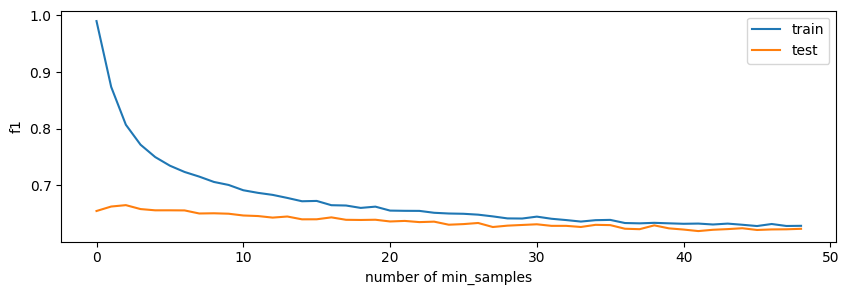

In [70]:
min_samples_leaf_array = range(1, 50)
train_f1_array = []
test_f1_array = []
for  min_samples_leaf in tqdm(min_samples_leaf_array):
    model = RandomForestClassifier(n_estimators=40, min_samples_leaf=min_samples_leaf, random_state=13)
    model.fit(X_train, y_train)
    train_f1_array.append(f1(y_train, model.predict(X_train)))
    test_f1_array.append(f1(y_val, model.predict(X_test)))

plt.plot(train_f1_array, label='train')
plt.plot(test_f1_array, label='test')
plt.xlabel('number of min_samples')
plt.ylabel('f1')
plt.legend();

min_samples=80

100%|██████████| 14/14 [00:28<00:00,  2.03s/it]


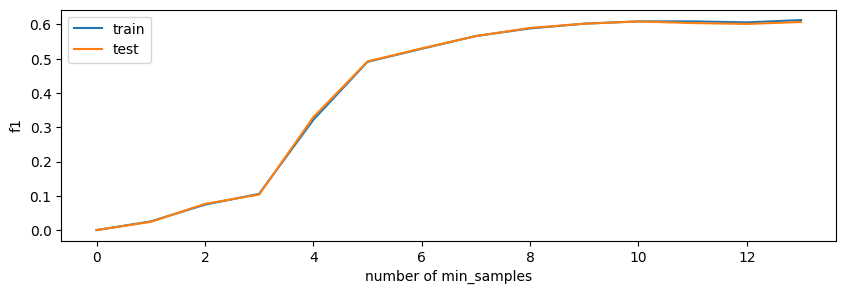

In [71]:
max_depth_array = range(1, 15)
train_f1_depth = []
test_f1_depth = []
for  max_depth in tqdm(max_depth_array):
    model = RandomForestClassifier(n_estimators=40, min_samples_leaf=80,max_depth=max_depth, random_state=13)
    model.fit(X_train, y_train)
    train_f1_depth.append(f1(y_train, model.predict(X_train)))
    test_f1_depth.append(f1(y_val, model.predict(X_test)))

plt.plot(train_f1_depth, label='train')
plt.plot(test_f1_depth, label='test')
plt.xlabel('number of min_samples')
plt.ylabel('f1')
plt.legend();

✅ if random forest overfits under training process almost needs
large interval of time

focus on score time

In [72]:
model=RandomForestClassifier(n_estimators=40, min_samples_leaf=80,max_depth=10, random_state=13)

In [73]:
result(X_train=X_train,X_val=X_test,y_train=y_train,y_val=y_val,estimator=model)

croos_validates results  


,fit_time,score_time,test_ACC,train_ACC,test_F1,train_F1,test_Precision,train_Precision,test_Recall,train_Recall
0,1.495427,0.086613,0.808267,0.811806,0.592331,0.598638,0.720791,0.731666,0.502734,0.506542
1,1.500924,0.087328,0.810561,0.807914,0.596248,0.589446,0.727853,0.722753,0.504948,0.497657
2,1.487841,0.086486,0.803780,0.809609,0.573801,0.591779,0.720582,0.728901,0.476699,0.498080
3,1.493257,0.085002,0.810778,0.810096,0.601065,0.595839,0.722751,0.726031,0.514449,0.505240
4,1.562981,0.116113,0.806882,0.810006,0.589983,0.598621,0.716518,0.721793,0.501432,0.511358




test_ACC           0.808054
train_ACC          0.809886
test_F1            0.590686
train_F1           0.594865
test_Precision     0.721699
train_Precision    0.726229
test_Recall        0.500052
train_Recall       0.503775
dtype: float64
              precision    recall  f1-score   support

    canceled       0.83      0.92      0.88     12546
not canceled       0.71      0.52      0.60      4782

    accuracy                           0.81     17328
   macro avg       0.77      0.72      0.74     17328
weighted avg       0.80      0.81      0.80     17328



<Figure size 1000x300 with 0 Axes>

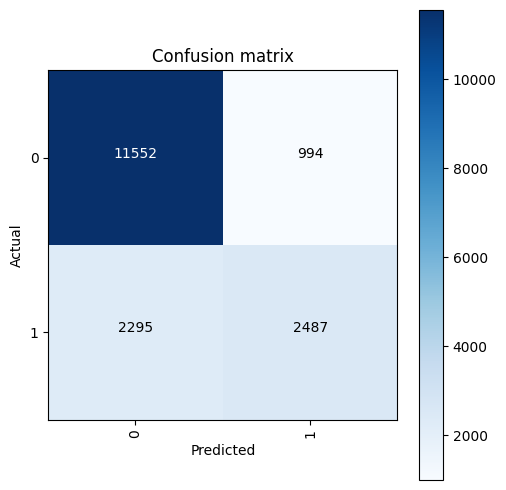

Precision =     0.714
Recall    =     0.520
F1_score  =     0.602


In [74]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

# Confusion maxtrix & metrics
cm = confusion_matrix(y_val, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm,
                      classes = class_names, )
plt.savefig('2.xgb_cfl_confusion_matrix.png')
plt.show()

show_metrics(cm)

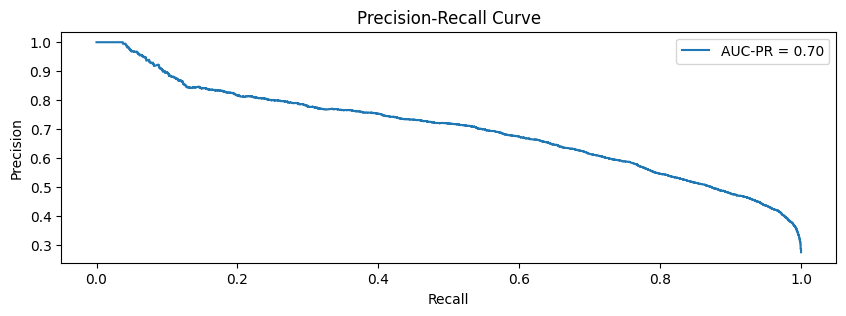

In [75]:
curve(y_val,model.predict_proba(X_test)[:,1])

A score of 70 indicates that the model's ability to distinguish between the classes is moderate. Higher values (closer to 1) indicate better performance.
in general we can train several models wiht best parameters but finally we can choose best model based on roc curve performance.

best performance  under condition roc curve is a guarantee of model stability differ from thershold

In [76]:

importances = list(model.feature_importances_)
feature_list = list(X_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

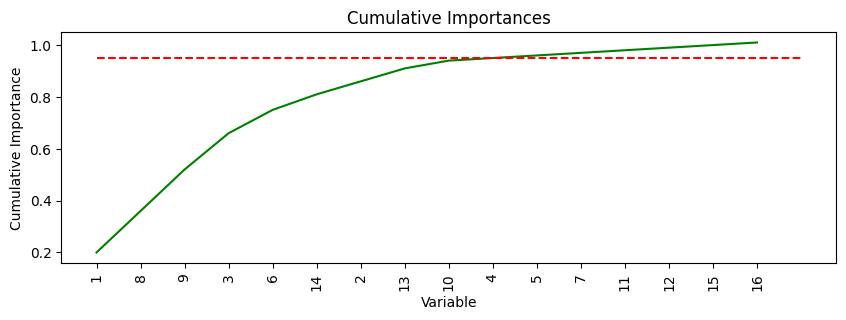

In [77]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances][:50]
sorted_features = [importance[0] for importance in feature_importances][:50]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
x_values = list(range(len(importances)))
# Make a line graph
plt.plot(x_values[:50], cumulative_importances[:50], 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values[:50], sorted_features[:50], rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [78]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 10


In [79]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:10]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = X_train.iloc[:, important_indices]
important_test_features = X_test.iloc[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (69311, 10)
Important test features shape: (17328, 10)


In [80]:
# Fit the random search model
model.fit(important_train_features, y_train);

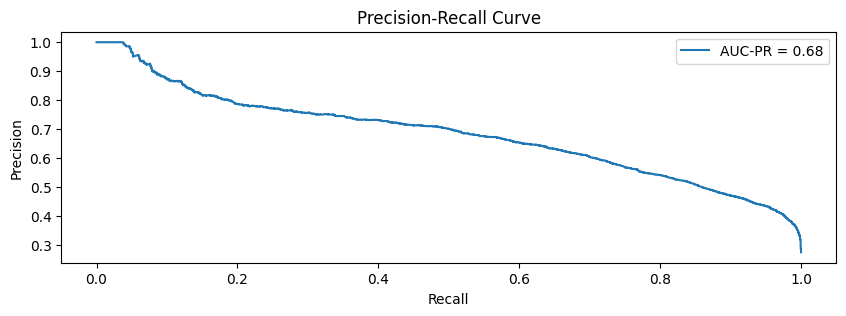

In [81]:
curve(y_val,model.predict_proba(important_test_features)[:,1])

In [82]:
result(X_train=important_train_features,X_val=important_test_features,
       y_train=y_train,y_val=y_val,estimator=model)

croos_validates results  


,fit_time,score_time,test_ACC,train_ACC,test_F1,train_F1,test_Precision,train_Precision,test_Recall,train_Recall
0,1.258341,0.082775,0.805453,0.807044,0.587678,0.591657,0.711852,0.715169,0.500391,0.504524
1,1.227927,0.083842,0.808686,0.806597,0.600482,0.597387,0.712294,0.705820,0.519010,0.517834
2,1.436223,0.106740,0.801327,0.807084,0.577607,0.592883,0.702874,0.713801,0.490237,0.506997
3,1.770611,0.084018,0.805800,0.806813,0.596160,0.595743,0.703363,0.708846,0.517313,0.513767
4,1.244821,0.081985,0.801977,0.807859,0.583523,0.597019,0.699273,0.712596,0.500651,0.513702




test_ACC           0.804649
train_ACC          0.807080
test_F1            0.589090
train_F1           0.594938
test_Precision     0.705931
train_Precision    0.711246
test_Recall        0.505520
train_Recall       0.511365
dtype: float64
              precision    recall  f1-score   support

    canceled       0.83      0.91      0.87     12546
not canceled       0.69      0.51      0.59      4782

    accuracy                           0.80     17328
   macro avg       0.76      0.71      0.73     17328
weighted avg       0.79      0.80      0.79     17328



For some models, reducing the number of features can improve the result and therefore should be done.

KNN

- $w(d) = \frac{1}{d+a}$,
Taking the weight $\frac{1}{d}$ is an unsuccessful solution because when $d = 0$, the weight will be infinitely large.

In sklearn, this situation is bypassed by assigning a weight of 1 to such an object, while all other objects will have a weight of 0.

In [83]:
from sklearn.neighbors import KNeighborsClassifier

def calc_weight_n_neigbours(dists):
    weights = np.zeros(dists.shape)

    for i in range(dists.shape[1]):
        weights[:, i] = 1/(i+1)

    return weights

In [84]:
from sklearn.model_selection import StratifiedKFold
parameters = {'n_neighbors':np.arange(1,30,4),
              'weights':['uniform', 'distance',calc_weight_n_neigbours],
              'metric':["minkowski",'euclidean']}
kNN_search = GridSearchCV(estimator = KNeighborsClassifier(),
                          verbose = 3,
                          param_grid=parameters ,
                          cv=StratifiedKFold(n_splits=3)
                          )

In [85]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.766 total time=   6.3s
[CV 2/3] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.771 total time=   7.8s
[CV 3/3] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.763 total time=   6.2s
[CV 1/3] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.766 total time=   6.4s
[CV 2/3] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.771 total time=   5.0s
[CV 3/3] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.763 total time=   6.0s
[CV 1/3] END metric=minkowski, n_neighbors=1, weights=<function calc_weight_n_neigbours at 0x7bc244347910>;, score=0.766 total time=   5.4s
[CV 2/3] END metric=minkowski, n_neighbors=1, weights=<function calc_weight_n_neigbours at 0x7bc244347910>;, score=0.771 total time=   5.0s
[CV 3/3] END metric=minkowski, n_neighbors=1, weights=<function calc_weight_n_neigbou

In [86]:
kNN_search.best_estimator_

KNeighborsClassifier(n_neighbors=29, weights='distance')

In [87]:
DF_class=pd.DataFrame(kNN_search.cv_results_)

DF = DF_class[['param_n_neighbors','param_weights',
               'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("seagreen", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
46,29,distance,0.801590,0.001532,1
22,29,distance,0.801590,0.001532,1
40,21,distance,0.801518,0.001297,3
16,21,distance,0.801518,0.001297,3
43,25,distance,0.801518,0.001314,5
19,25,distance,0.801518,0.001314,5
37,17,distance,0.800248,0.001608,7
13,17,distance,0.800248,0.001608,7
23,29,,0.800118,0.000781,9
47,29,,0.800118,0.000781,9


In stratified k-fold cross-validation with n_splits=3, the dataset will be split into 3 folds. For each fold:

Two-thirds of the data will be used for training (train).
One-third of the data will be used for validation (validation).
So, it's not (3, 3) as you mentioned. Instead, it's more like:

cv1: (train1, train2, validation1)

cv2: (train1, train3, validation2)

cv3: (train2, train3, validation3)

Each fold will cover all instances in the dataset exactly once for validation, with the remaining instances used for training. This ensures that the entire dataset is utilized for both training and validation across all folds, providing a robust estimate of the model's performance.

typically, a smaller standard deviation (std) in cross-validation results indicates that the model's performance is more consistent across different folds. A smaller std suggests that the model's performance is less sensitive to the specific training/validation split, which is desirable as it indicates a more stable and reliable model.

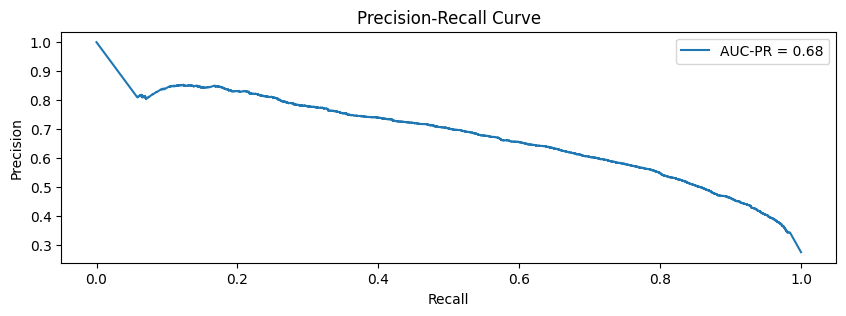

In [88]:
curve(y_val,kNN_search.best_estimator_.predict_proba(X_test)[:,1])

#LogisticRegression

In [89]:

lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

LogisticRegressionWithThreshold()

In [90]:

threshold, optimal_f1_score = lrt.threshold_from_optimal_f_score(X_train, y_train)
y_pred = lrt.predict(X_test, threshold)

threshold, optimal_f1_score

(0.28456122591209837, 0.5998023507643138)

In [91]:
log_predict=lrt.predict_proba(X_test)[:,1]

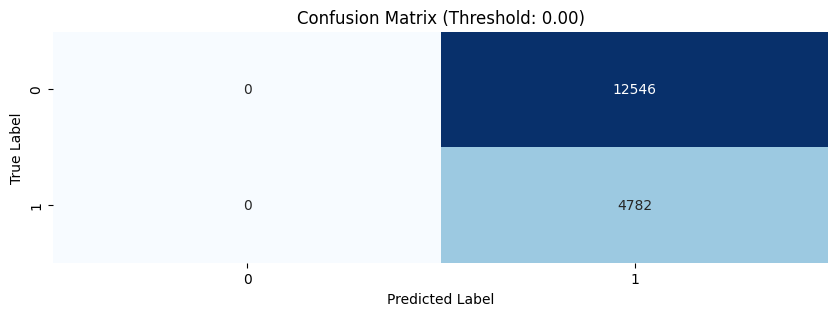

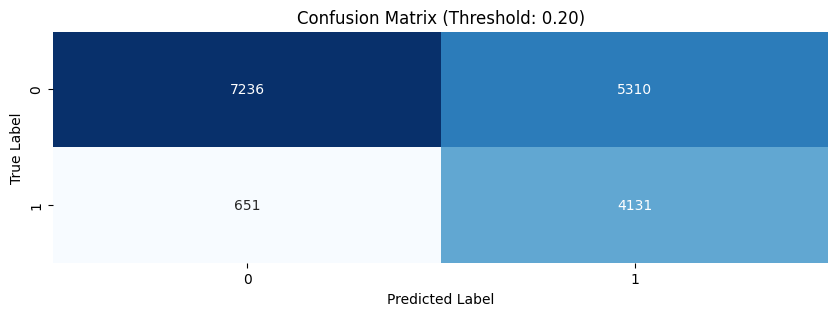

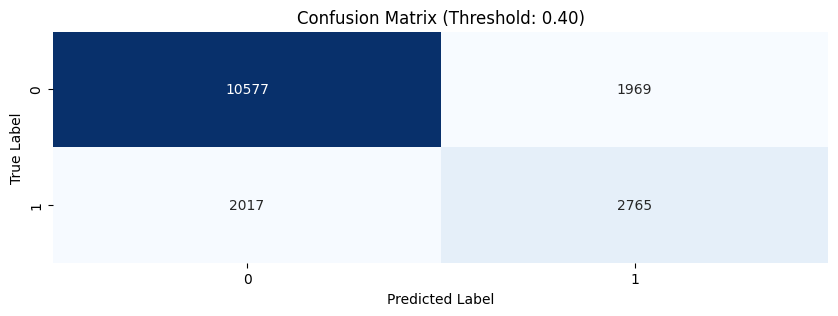

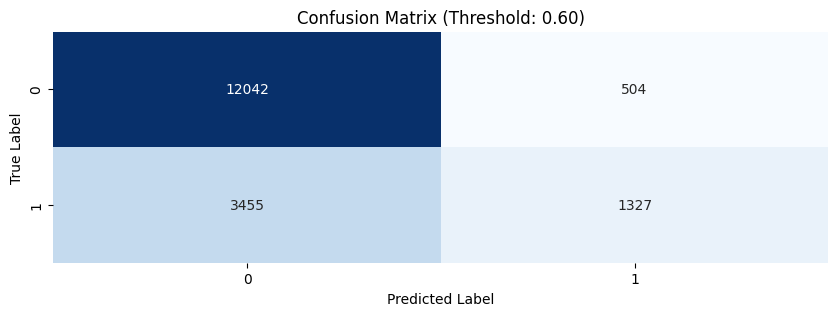

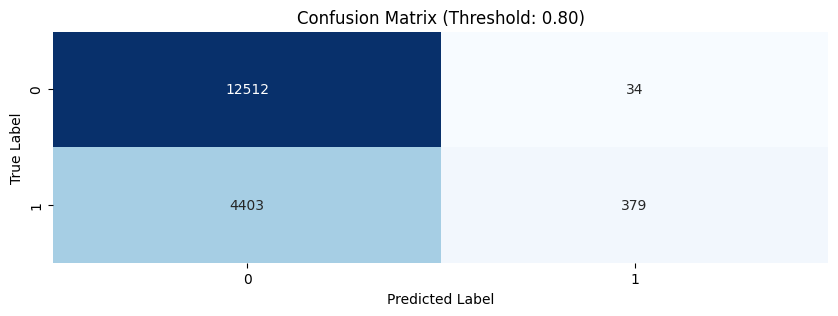

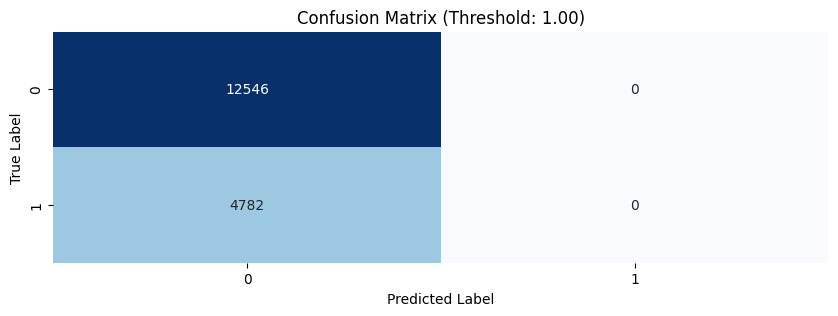

In [92]:
thresholds = np.arange(0, 1.01, 0.2)  # Threshold values from 0 to 1 with step 0.01
metrics_list = []
# Initialize lists to store confusion matrices for each threshold
confusion_matrices = []

# Iterate over thresholds
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    predicted_labels = (log_predict > threshold).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_val, predicted_labels)

    # Append confusion matrix to the list
    confusion_matrices.append((threshold, cm))

# Plot confusion matrices
for threshold, cm in confusion_matrices:
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix (Threshold: {threshold:.2f})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

#*additional

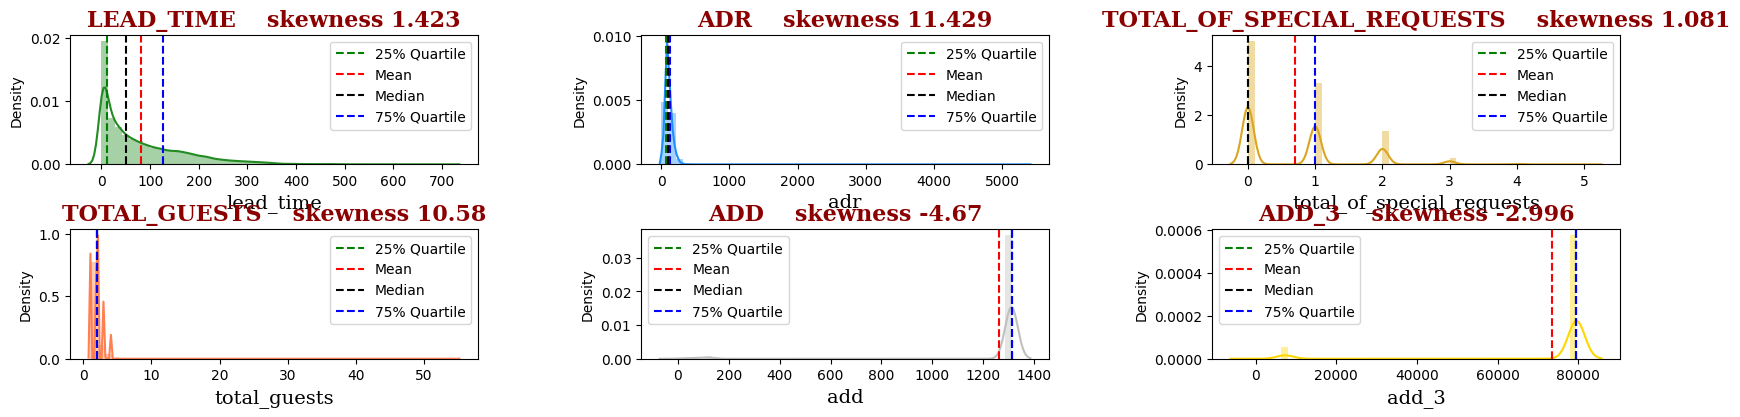

In [93]:
colours = ['forestgreen','dodgerblue','goldenrod', 'coral' , 'silver' , 'gold' ]
# create fontdicts for formatting figure text
axtitle_dict = {'family': 'serif','color':  'darkred','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}
#create figure with 3 x 3 grid of subplots
fig = plt.figure(figsize=[20,4])
#fig.suptitle('DISTPLOT OF dATA', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(num_cols):
    ax = fig.add_subplot(2, 3, i+1)
    ax = sns.distplot(final_df[col],  color=colours[i])
    ax.axvline(final_df[col].quantile(q=0.25),color='green',linestyle='--',label='25% Quartile')
    ax.axvline(final_df[col].mean(),color='red',linestyle='--',label='Mean')
    ax.axvline(final_df[col].median(),color='black',linestyle='--',label='Median')
    ax.axvline(final_df[col].quantile(q=0.75),color='blue',linestyle='--',label='75% Quartile')
    # ax.text('skewness: {}' .format(str(round(df[col].skew(),3))), ha='right', va='center', size=11)
    ax.set_xlabel(f'{col}', fontdict=axlab_dict)
    ax.set_title(f'{col.upper()}    skewness {round(final_df[col].skew(),3)}', fontdict=axtitle_dict)
    ax.legend(fontsize=10)

please check more about outlire detection

author : Zviadi Beridze

reference : https://github.com/AILogoSkill/ML_Projects/blob/main/Project_Outlire_Detection.ipynb

#for PCA
it is important to choose n_component correctly ,
in the case where pca(0.95) not almost correctly becaouse
PCA choose first n_component and metric will be uncorrectly


example

 pca(0.95) n_components =60 ---> r2_score=0.76

 pca(0.95) n_components =71 ---> r2_score=0.81

In [94]:
numerical_pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('poly', PolynomialFeatures(degree=3)),
    ('power', PowerTransformer()),#for transforming to Normal Distribution
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols),
    ('pass', 'passthrough', extra_cat_cols)  # 'passthrough' means no transformation
])

#X_train = preprocessors.fit_transform(X_train, y_train)
#X_test = preprocessors.transform(X_val)

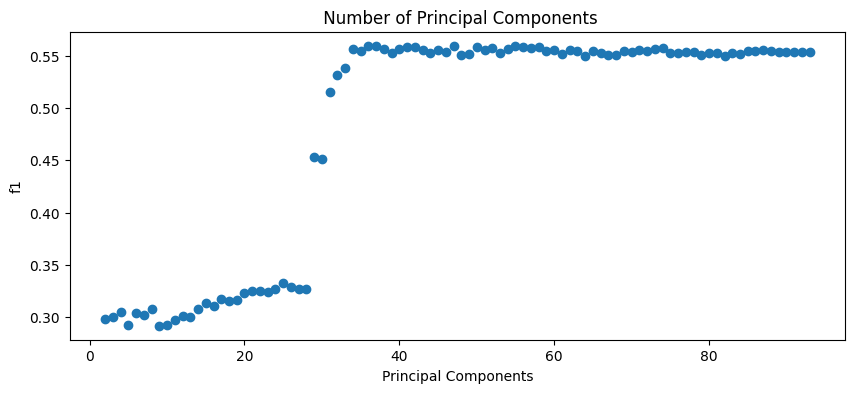

In [95]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X2=preprocessors.fit_transform(X,y)
X2=pd.DataFrame(X2)
def do_pca(n_components,X):
  pca=PCA(n_components)
  X_pca=pca.fit_transform(X2)
  return pca,X_pca



def fit_L_R(X, y, print_output=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)

    clf =LogisticRegression()
    clf.fit(X_train, y_train)

    y_preds = clf.predict(X_test)

    f1_=f1(y_test, y_preds)

    return f1_


acc_list, pc_list = [], []
for pc in range(2,X2.shape[1]):
    pca, X_pca = do_pca(pc,X2)
    acc = fit_L_R(X_pca,y)
    acc_list.append(acc)
    pc_list.append(pc)

plt.figure(figsize=[10,4])
plt.scatter(pc_list, acc_list)
plt.title(' Number of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('f1');

In [96]:
X_train,X_val,y_train,y_val=train_test_split(X, y,
                                            test_size=0.2,
                                            random_state=42)

numerical_pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=4)),
    ('poly', PolynomialFeatures(degree=4)),
    ('power', PowerTransformer()),#for transforming to Normal Distribution
    ('PCA', PCA(n_components=61)),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols),
    ('pass', 'passthrough', extra_cat_cols)  # 'passthrough' means no transformation
])


X_train = preprocessors.fit_transform(X_train, y_train)
X_test = preprocessors.transform(X_val)

In [97]:
from sklearn.model_selection import RandomizedSearchCV

pipeline = Pipeline(steps=[
    ('model',  ClfSwitcher())
])

params_log = {
    'model': (LogisticRegression(),),
    'model__C':np.logspace(-1, 2, 20),
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': [{0: 0.72, 1: 0.28}],
}
# search across 100 different combinations, and use all available cores
random = RandomizedSearchCV(estimator=pipeline, param_distributions=params_log,
                              n_iter = 100, scoring='f1',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)
random.fit(X_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=Pipeline(steps=[('model', ClfSwitcher())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model': (LogisticRegression(C=7.847599703514611,
                                                                     class_weight={0: 0.72,
                                                                                   1: 0.28}),),
                                        'model__C': array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ]),
                                        'model__class_weight': [{0: 0.72,
                                                                 1: 0.28}],
                                        'model__penalty': ['l1', 'l2']},
                   random_state=42, return_train_score=True, scoring='f1',
                   verbose=2)

In [98]:
random.best_estimator_

Pipeline(steps=[('model',
                 LogisticRegression(C=7.847599703514611,
                                    class_weight={0: 0.72, 1: 0.28}))])

In [99]:
result(X_train=X_train,X_val=X_test,y_train=y_train,y_val=y_val,estimator=random.best_estimator_)

croos_validates results  


,fit_time,score_time,test_ACC,train_ACC,test_F1,train_F1,test_Precision,train_Precision,test_Recall,train_Recall
0,1.200903,0.034865,0.763543,0.764771,0.311345,0.317513,0.806311,0.809498,0.192919,0.197487
1,1.106939,0.036341,0.761146,0.763098,0.294782,0.307027,0.809357,0.810134,0.180208,0.189404
2,1.193603,0.032646,0.762805,0.762683,0.306914,0.306655,0.806202,0.804757,0.189534,0.189416
3,1.203885,0.038376,0.765113,0.762827,0.321101,0.309985,0.806283,0.799242,0.200469,0.192280
4,1.212217,0.032431,0.764031,0.763386,0.316976,0.312081,0.800633,0.802373,0.197605,0.193712




test_ACC           0.763328
train_ACC          0.763353
test_F1            0.310224
train_F1           0.310652
test_Precision     0.805757
train_Precision    0.805201
test_Recall        0.192147
train_Recall       0.192460
dtype: float64
              precision    recall  f1-score   support

    canceled       0.76      0.98      0.86     12546
not canceled       0.80      0.19      0.30      4782

    accuracy                           0.76     17328
   macro avg       0.78      0.58      0.58     17328
weighted avg       0.77      0.76      0.70     17328



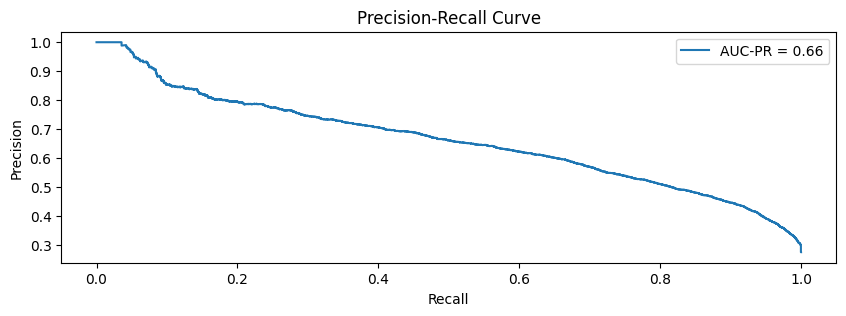

In [100]:
curve(y_val,random.best_estimator_.predict_proba(X_test)[:,1])

While feature engineering is crucial, it's also essential to strike a balance and avoid over-engineering features. Complex features may increase model complexity and training time without necessarily improving performance. Therefore, it's essential to experiment, validate, and iterate on feature engineering steps to find the optimal set of features for a given problem